<a href="https://colab.research.google.com/github/seunghyeokkim/ByeolDaJul/blob/main/%5B%EB%AA%A8%EB%8D%B8_1%5DLSTM_with_attention_%EC%9D%98%EB%8F%84_%EB%B6%84%EC%84%9D(0911)_%EC%9D%80%EC%A7%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 불러오기

In [ ]:
#형태소 분석기 konlpy 설치

!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 37.9 MB/s eta 0:00:00


In [ ]:
import os

import numpy as np
import pandas as pd

from datetime import datetime
import json
import re

from konlpy.tag import Okt # komoran, han, kkma #형태소 분석기 (형태소 단위로 토큰화. 품사태깅해서 반환. 명사만 반환)

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tqdm.notebook import tqdm

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/warnikchow/sae4k/master/data/sae4k_v2.txt', sep='\t', encoding = 'utf-8',header=None)
data.columns = ['label','Pair_1', 'Pair_2']
data

,label,Pair_1,Pair_2
0,2,이번 주에 기온변화가 가장 큰 요일을 알려줘,이번 주 기온변화 가장 큰 요일
1,0,공기청정기 켜져있니,공기청정기 켜졌는지
2,0,오늘 오후에 수영대회가 있니,오늘 오후 수영대회 여부
3,3,가급적 아이리버 엠피쓰리는 사지 않도록 합시다,아이리버 엠피쓰리 사지 않기
4,3,전체 메일을 쓸 때 민감한 내용은 쓰지마,민감한 내용 전체메일 보내지 않기
...,...,...,...
50832,2,청포묵과 우묵가사리는 대체 뭐가 다른거니,청포묵과 우묵가사리의 차이
50833,2,역사에서 협상으로 전쟁을 대신한 사례가 뭐가 있지,전쟁을 협상으로 대처한 사례
50834,4,거실 조명 하나만 꺼 줘,거실 조명 하나만 끄기
50835,0,내게 쓴 메일함 다 비웠니,내게 쓴 메일함 다 비웠는지


In [ ]:
data['label2'] = data['label']
data

,label,Pair_1,Pair_2,label2
0,2,이번 주에 기온변화가 가장 큰 요일을 알려줘,이번 주 기온변화 가장 큰 요일,2
1,0,공기청정기 켜져있니,공기청정기 켜졌는지,0
2,0,오늘 오후에 수영대회가 있니,오늘 오후 수영대회 여부,0
3,3,가급적 아이리버 엠피쓰리는 사지 않도록 합시다,아이리버 엠피쓰리 사지 않기,3
4,3,전체 메일을 쓸 때 민감한 내용은 쓰지마,민감한 내용 전체메일 보내지 않기,3
...,...,...,...,...
50832,2,청포묵과 우묵가사리는 대체 뭐가 다른거니,청포묵과 우묵가사리의 차이,2
50833,2,역사에서 협상으로 전쟁을 대신한 사례가 뭐가 있지,전쟁을 협상으로 대처한 사례,2
50834,4,거실 조명 하나만 꺼 줘,거실 조명 하나만 끄기,4
50835,0,내게 쓴 메일함 다 비웠니,내게 쓴 메일함 다 비웠는지,0


In [ ]:
data.drop('label',axis=1,inplace=True)
data.columns = ['Pair_1','Pair_2','label']
data

,Pair_1,Pair_2,label
0,이번 주에 기온변화가 가장 큰 요일을 알려줘,이번 주 기온변화 가장 큰 요일,2
1,공기청정기 켜져있니,공기청정기 켜졌는지,0
2,오늘 오후에 수영대회가 있니,오늘 오후 수영대회 여부,0
3,가급적 아이리버 엠피쓰리는 사지 않도록 합시다,아이리버 엠피쓰리 사지 않기,3
4,전체 메일을 쓸 때 민감한 내용은 쓰지마,민감한 내용 전체메일 보내지 않기,3
...,...,...,...
50832,청포묵과 우묵가사리는 대체 뭐가 다른거니,청포묵과 우묵가사리의 차이,2
50833,역사에서 협상으로 전쟁을 대신한 사례가 뭐가 있지,전쟁을 협상으로 대처한 사례,2
50834,거실 조명 하나만 꺼 줘,거실 조명 하나만 끄기,4
50835,내게 쓴 메일함 다 비웠니,내게 쓴 메일함 다 비웠는지,0


In [ ]:
map_dictionary = {0:'여부', 1:'선택', 2:'wh질문', 3:'금지', 4:'요구', 5:'강한요구'}
data['intent'] = data['label'].map(map_dictionary)
data

,Pair_1,Pair_2,label,intent
0,이번 주에 기온변화가 가장 큰 요일을 알려줘,이번 주 기온변화 가장 큰 요일,2,wh질문
1,공기청정기 켜져있니,공기청정기 켜졌는지,0,여부
2,오늘 오후에 수영대회가 있니,오늘 오후 수영대회 여부,0,여부
3,가급적 아이리버 엠피쓰리는 사지 않도록 합시다,아이리버 엠피쓰리 사지 않기,3,금지
4,전체 메일을 쓸 때 민감한 내용은 쓰지마,민감한 내용 전체메일 보내지 않기,3,금지
...,...,...,...,...
50832,청포묵과 우묵가사리는 대체 뭐가 다른거니,청포묵과 우묵가사리의 차이,2,wh질문
50833,역사에서 협상으로 전쟁을 대신한 사례가 뭐가 있지,전쟁을 협상으로 대처한 사례,2,wh질문
50834,거실 조명 하나만 꺼 줘,거실 조명 하나만 끄기,4,요구
50835,내게 쓴 메일함 다 비웠니,내게 쓴 메일함 다 비웠는지,0,여부


## 데이터 전처리

In [ ]:
def preprocessing(message, okt):
    # message : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.

    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    pattern = '[^가-힣\s]+'
    message = re.sub(pattern, ' ', message)

    # 2. okt 객체를 활용해서 형태소 단위(품사까지 반환)로 나눈다.
    origin_message = okt.pos(message, stem=True)

    # 3. token만 모아둔다.
    fin_message = [token for token, pos in origin_message]

    return fin_message

In [ ]:
#문장과 의도 데이터를 나눈다.
sent = data['Pair_1']
intent = data['label']

In [ ]:
# source 데이터 전처리
from tqdm import tqdm

def load_preprocessed_data(sent):
    sent_input = []

    for src_line in tqdm(sent):

        sent_line = preprocessing(src_line, okt)

        sent_input.append(sent_line)

    return sent_input

In [ ]:
okt = Okt()
sents_in = load_preprocessed_data(sent)
intent_out = np.array(intent)

100%|██████████| 50837/50837 [01:23<00:00, 608.04it/s]


In [ ]:
sents_in

[['이번', '주', '에', '기', '온', '변화', '가', '가장', '크다', '요일', '을', '알다'],
 ['공기청정기', '켜다'],
 ['오늘', '오후', '에', '수', '영', '대회', '가', '있다'],
 ['가급적', '아이리버', '엠피쓰리', '는', '사지', '않다', '하다'],
 ['전체', '메일', '을', '쓸다', '때', '민감하다', '내용', '은', '쓰다'],
 ['이번', '주', '에', '눈', '언제', '내리다'],
 ['네이버', '메일', '이용', '시', '사용', '하다', '수', '있다', '클라우드', '서비스', '가', '뭐', '야'],
 ['혀', '를', '깨물다', '왜', '죽다'],
 ['화장실', '환풍기', '틀어주다'],
 ['내일', '오전', '울릉도', '에', '바람', '이', '얼마나', '불다', '알다'],
 ['동아대', '근처', '많이', '가다', '밥집', '어떻다', '가다'],
 ['소나기', '가', '몇', '시', '에', '내', '리기', '시작', '하다'],
 ['오늘', '일정', '에', '저녁', '약속', '이', '있다'],
 ['페이스북', '이랑', '인스타그램', '중', '이메일', '로', '로그인', '하다', '뭐', '지'],
 ['메일', '함', '에서', '학회', '검색', '해주다'],
 ['운동', '스케쥴', '미루다', '한도', '끝', '도', '없다', '미루다', '마'],
 ['가장', '인기', '많다', '라떼', '는', '어느', '것입', '니까'],
 ['다음', '달', '육일', '오전', '아홉시', '에', '수강신청', '일정', '추가', '해주다'],
 ['요리', '레시피', '요청', '하고', '싶다', '때', '는', '어떻다', '말', '하다'],
 ['오늘', '오후', '비다', '확인', '하다', '알다'],
 ['집합론', '

In [ ]:
intent_out

array([2, 0, 0, ..., 4, 0, 4])

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 인풋 데이터

#토크나이저
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(sents_in)
sent_input = input_tokenizer.texts_to_sequences(sents_in)


word_vocab = input_tokenizer.word_index # 딕셔너리 형태
print("전체 단어 개수: ", len(word_vocab)) # 전체 단어 개수 확인

max_input_length = max(len(seq) for seq in sent_input) #최대 단어 길이

#패딩
sent_input = pad_sequences(sent_input, maxlen=max_input_length, padding="pre")


전체 단어 개수:  10756


In [ ]:
NUM_TOTAL = len(sent)
NUM_TOTAL

50837

In [ ]:
#전체 데이터 중 Test 10% 분할
val_num = int(NUM_TOTAL * 0.1)
val_num

X_train = sent_input[:-val_num]
X_test = sent_input[val_num:]
y_train = intent_out[:-val_num]
y_test = intent_out[val_num:]

5083

In [ ]:
len(X_test)

45754

In [ ]:
X_train

array([[   0,    0,    0, ...,  282,    7,    8],
       [   0,    0,    0, ...,    0,  740,   47],
       [   0,    0,    0, ..., 1139,    6,    5],
       ...,
       [   0,    0,    0, ...,  121,  282,    8],
       [   0,    0,    0, ...,    2,  396,   35],
       [   0,    0,    0, ...,   21, 4716,  316]], dtype=int32)

In [ ]:
len(y_test)

45754

In [ ]:
#전체 단어집합의 개수
vocab_size = len(word_vocab)+1
vocab_size

10757

In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Flatten
from tensorflow.keras.models import Model

#LSTM의 마지막 h을 context vector로 받아서 -> attention

input = Input(shape=(None,))
emb = Embedding(vocab_size, 100)(input) #모든 단어를 100차원으로 embedding.
lstm_output, h, c = LSTM(256, return_sequences = False, return_state=True)(emb) #LSTM 256노드 사용
att = Attention(dropout = 0.5)([lstm_output, h]) #return_sequence를 False로 넣어놔서 마지막 h만 attention에 반환
x = Flatten()(att)
output = Dense(6, activation='softmax')(x) #라벨 6개 확률값 반환

model = Model(inputs = input, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 100)            1075700   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 256),                365568    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [ ]:
#모델  컴파일
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early stop
es = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 4)

#모델 fit
tf.keras.callbacks.History()
history = model.fit(X_train, y_train, epochs = 7, batch_size = 64, validation_split = 0.2, callbacks = [es])

Epoch 1/7
572/572 [==============================] - 156s 273ms/step - loss: 0.2087 - sparse_categorical_accuracy: 0.9468 - val_loss: 0.3576 - val_sparse_categorical_accuracy: 0.9015
Epoch 2/7
572/572 [==============================] - 154s 269ms/step - loss: 0.1951 - sparse_categorical_accuracy: 0.9503 - val_loss: 0.3897 - val_sparse_categorical_accuracy: 0.9015
Epoch 3/7
572/572 [==============================] - 156s 274ms/step - loss: 0.1746 - sparse_categorical_accuracy: 0.9553 - val_loss: 0.3977 - val_sparse_categorical_accuracy: 0.9031
Epoch 4/7
572/572 [==============================] - 154s 269ms/step - loss: 0.1614 - sparse_categorical_accuracy: 0.9606 - val_loss: 0.4138 - val_sparse_categorical_accuracy: 0.8996
Epoch 5/7
572/572 [==============================] - 155s 271ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.3956 - val_sparse_categorical_accuracy: 0.9034
Epoch 5: early stopping


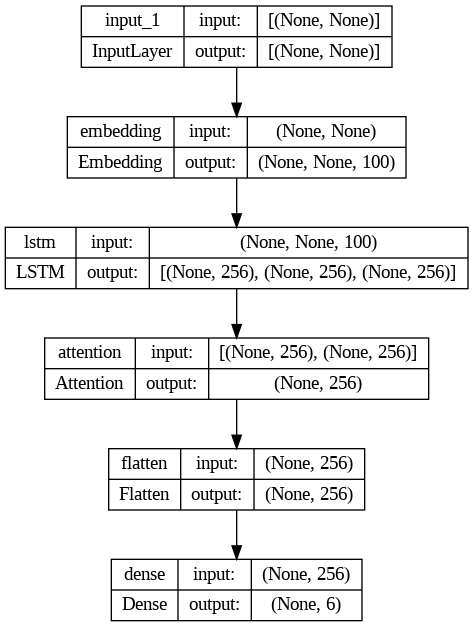

In [ ]:
#모델 시각
from tensorflow.keras.utils import plot_model

tf.keras.utils.plot_model(model, to_file='result3.png', show_shapes=True)

In [ ]:
#모델 예측값
pred_result = model.predict(X_test)

1430/1430 [==============================] - 70s 49ms/step


In [ ]:
#X_test에 대한 예측값 출력
pred_result

array([[3.8238122e-06, 8.4546889e-04, 1.0212901e-05, 4.3074773e-03,
        6.8038492e-04, 9.9415255e-01],
       [9.5046480e-04, 8.6287677e-05, 9.9711126e-01, 2.7423932e-05,
        1.8154883e-03, 8.9181012e-06],
       [2.2981832e-02, 2.7241543e-04, 6.7034928e-04, 2.2283476e-03,
        9.7336447e-01, 4.8258799e-04],
       ...,
       [4.1904384e-03, 4.9143011e-04, 5.9262553e-04, 4.4014095e-03,
        9.8789859e-01, 2.4254015e-03],
       [1.3573830e-01, 8.8659086e-04, 1.9686816e-03, 7.5695803e-03,
        8.5337824e-01, 4.5861086e-04],
       [3.7236221e-03, 5.4896227e-04, 6.5969233e-04, 4.6432712e-03,
        9.8664480e-01, 3.7795727e-03]], dtype=float32)

In [ ]:
#가장 예측값이 높은 값의 인덱스
pred_label = [np.argmax(pred_result[i]) for i in range(len(pred_result))]
pred_label

[5,
 2,
 4,
 3,
 0,
 4,
 3,
 2,
 1,
 0,
 4,
 4,
 5,
 4,
 4,
 2,
 4,
 2,
 4,
 2,
 4,
 1,
 0,
 3,
 4,
 2,
 0,
 4,
 2,
 1,
 2,
 4,
 0,
 2,
 4,
 4,
 2,
 1,
 0,
 4,
 5,
 4,
 2,
 2,
 1,
 4,
 2,
 3,
 2,
 3,
 2,
 3,
 1,
 4,
 5,
 0,
 2,
 4,
 0,
 3,
 4,
 2,
 3,
 0,
 2,
 1,
 2,
 2,
 0,
 3,
 4,
 5,
 2,
 4,
 2,
 0,
 4,
 2,
 4,
 4,
 0,
 4,
 5,
 1,
 2,
 2,
 2,
 2,
 4,
 0,
 2,
 4,
 5,
 4,
 5,
 3,
 4,
 4,
 1,
 5,
 0,
 2,
 5,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 5,
 4,
 2,
 2,
 1,
 4,
 0,
 2,
 4,
 4,
 4,
 5,
 3,
 3,
 4,
 2,
 4,
 3,
 4,
 2,
 2,
 3,
 2,
 4,
 2,
 4,
 3,
 5,
 2,
 1,
 2,
 4,
 4,
 4,
 4,
 2,
 3,
 2,
 4,
 2,
 4,
 1,
 4,
 4,
 2,
 3,
 4,
 2,
 1,
 2,
 2,
 5,
 5,
 2,
 4,
 5,
 2,
 2,
 4,
 0,
 5,
 2,
 1,
 2,
 0,
 2,
 4,
 0,
 0,
 0,
 2,
 0,
 3,
 2,
 4,
 1,
 4,
 4,
 2,
 0,
 2,
 2,
 4,
 2,
 1,
 4,
 2,
 2,
 4,
 2,
 1,
 4,
 2,
 3,
 0,
 0,
 2,
 4,
 4,
 4,
 5,
 0,
 2,
 0,
 0,
 4,
 2,
 1,
 4,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 3,
 1,
 1,
 4,
 1,
 2,
 5,
 4,
 5,
 2,
 4,
 2,
 4,
 4,
 0,
 2,
 5,
 4,
 2,
 2,


In [ ]:
#X_test 문장 원본 복원
test_input = input_tokenizer.sequences_to_texts(X_test)
test_input

['이어폰 은 아무렇다 두다 말고 케이스 에 넣다 보관 하다 줄다',
 '이번 주 최대 온도 알다',
 '컴퓨터 화면 밝기 좀 조절 하다 주다 있다',
 '혹시 모르다 말 하다 두 니까 오늘 일정 잊어버리다 안 되다',
 '거실 불 꺼지다',
 '안방 에 에어컨 끄다',
 '방 어지럽히다 마',
 '동대문 에서 제일 싸다 술집 어떻다 가다',
 '침실 무드등 하고 형광등 중 너 가 켜다 싶다 뭐 야',
 '어제 오전 에 회사 에 보내다 메일 의 발신 여부 좀 확인 해주다',
 '유월 에 온 메일 모두 임시 보관 함 에 넣다',
 '아침 일곱시 에 깨우다',
 '최신 만화영화 를 볼 게 아니다 오래되다 걸 다시 보다 하다',
 '테레비 켜다',
 '내일 오전 에 회의 추가 해주다 수 있다',
 '내일 첫 약속 어디서 만나다 하다',
 '화장실 불 켜다 확인 해주다',
 '막내 는 언제 집 으로 돌아오다',
 '집 에 비디오카메라 챙기다',
 '오늘 제주도 풍량 을 어떻다',
 '투자 자산 분산 차원 에서 해외 펀드 를 가입 하다 필요 가 있다',
 '토네이도 와 허리케인 중 더 규모 가 크다 것 을 알다',
 '제대로 침입 경고 장치 세 팅 하다',
 '오늘 일정 놓치다 큰일 나 니까 잊어버리다 마',
 '오늘 은 일찍 가다 푹 쉬 지 그렇다',
 '자기 전 선풍기 시간 조절 방법 이 어떻다 돼다',
 '아고다 에서 예약 취소 확인 메일 이 오다',
 '외출 전 가스 밸브 를 확인 하다 주다 바라다',
 '이번 주 토요일 에 대구 날씨 좀 검색 해주다',
 '아웃룩 을 외부 메일 이랑 연동 하다 때 가 더 쉬다 지메일 을 연동 하다 때 가 더 쉬다',
 '너 네이버 메일 얼마 동안 안 쓰다 휴면 계정 이 되다 알 아',
 '뭐 하고 지내다 학원 다시 나오다 선생님 이 걱정 하다',
 '세탁기 지금 작동 시키다 있다',
 '메일 을 통해 배달 의 민족 결제 내 역 을 받다 방법 이 궁금하다',
 '저기 잠깐 만 요',
 '쿠쿠 밥솥 의 기능 에서 탕 요리 로 설정

In [ ]:
print(test_input[5])
print(pred_label[5])

안방 에 에어컨 끄다
4


In [ ]:
#모델 평가
model.evaluate(X_test, y_test)

1430/1430 [==============================] - 70s 49ms/step - loss: 0.2125 - sparse_categorical_accuracy: 0.9402


[0.21247945725917816, 0.9402019381523132]

In [ ]:
#X_test 예측 결과 {'sentence':'', 'label':''} 저장

result_li = []

map_dictionary = {0:'여부', 1:'선택', 2:'wh질문', 3:'금지', 4:'요구', 5:'강한 요구'}

for input, output in zip(test_input, pred_label):
    pred_intent = map_dictionary[output]
    result_li.append({'sentence':input, 'label':pred_intent})
result_li

[{'sentence': '이어폰 은 아무렇다 두다 말고 케이스 에 넣다 보관 하다 줄다', 'label': '강한 요구'},
 {'sentence': '이번 주 최대 온도 알다', 'label': 'wh질문'},
 {'sentence': '컴퓨터 화면 밝기 좀 조절 하다 주다 있다', 'label': '요구'},
 {'sentence': '혹시 모르다 말 하다 두 니까 오늘 일정 잊어버리다 안 되다', 'label': '금지'},
 {'sentence': '거실 불 꺼지다', 'label': '여부'},
 {'sentence': '안방 에 에어컨 끄다', 'label': '요구'},
 {'sentence': '방 어지럽히다 마', 'label': '금지'},
 {'sentence': '동대문 에서 제일 싸다 술집 어떻다 가다', 'label': 'wh질문'},
 {'sentence': '침실 무드등 하고 형광등 중 너 가 켜다 싶다 뭐 야', 'label': '선택'},
 {'sentence': '어제 오전 에 회사 에 보내다 메일 의 발신 여부 좀 확인 해주다', 'label': '여부'},
 {'sentence': '유월 에 온 메일 모두 임시 보관 함 에 넣다', 'label': '요구'},
 {'sentence': '아침 일곱시 에 깨우다', 'label': '요구'},
 {'sentence': '최신 만화영화 를 볼 게 아니다 오래되다 걸 다시 보다 하다', 'label': '강한 요구'},
 {'sentence': '테레비 켜다', 'label': '요구'},
 {'sentence': '내일 오전 에 회의 추가 해주다 수 있다', 'label': '요구'},
 {'sentence': '내일 첫 약속 어디서 만나다 하다', 'label': 'wh질문'},
 {'sentence': '화장실 불 켜다 확인 해주다', 'label': '요구'},
 {'sentence': '막내 는 언제 집 으로 돌아오다', 'label': 'wh질문'},
 {'sente

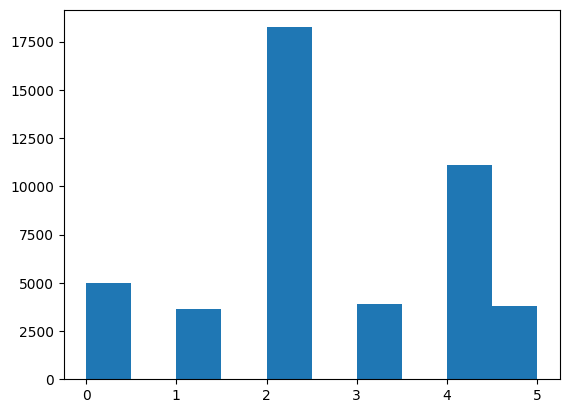

In [ ]:
#라벨 개수 시각화
import matplotlib.pyplot as plt

plt.hist(pred_label)
plt.show()

##Inference(추론)

In [ ]:
#데이터 전처리 + Tokenizer + Padding + 모델 predict

def inference(text):
    pattern = '[^가-힣0-9\s]'
    message = re.sub(pattern, ' ', text)

    origin_message = okt.pos(message, stem=True)

    fin_message = [token for token, pos in origin_message]

    sents_in = []
    for w in fin_message:
        sents_in.append(w)

    #모델 학습 시 사용한 tokenizer 사용
    input_tokenizer.fit_on_texts(sents_in)
    sent_input = input_tokenizer.texts_to_sequences([sents_in])
    print(sent_input)

    word_vocab = input_tokenizer.word_index
    word_vocab = len(word_vocab)+1

    # max_input_length = max(len(seq) for seq in sent_input)

    sent_input = pad_sequences(sent_input, maxlen=20, padding="pre")
    # print(sent_input)

    pred_result = model.predict(sent_input)

    pred_label = pred_result[0].argmax()
    print(pred_result)

    test_input = ' '.join(input_tokenizer.sequences_to_texts(sent_input))

    map_dictionary = {0:'여부', 1:'선택', 2:'wh질문', 3:'금지', 4:'요구', 5:'강한 요구'}

    pred_intent = map_dictionary[pred_label]

    return print(f'문장:{test_input}, 의도:{pred_intent}')


In [ ]:
#추론 해보기

inference('네가 소유하고 싶은 건 버스와 핸드백 중에 무엇이니')
#집에만 있어 밖에 나가지 말고 - 강한 요구


[[980, 1225, 2, 34, 713, 2224, 6, 53, 633, 816, 13, 1448]]
1/1 [==============================] - 0s 24ms/step
[[0.21720421 0.2652925  0.03277453 0.37855837 0.09871516 0.00745524]]
문장:관악산 등반 하다 때 일반 운동화 가 아니다 등산 화 를 신다, 의도:금지


##Batch_size 간 성능 비교 (Overfitting 분석)

In [ ]:
#Batch_size = 32
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early stop
es = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 4)

tf.keras.callbacks.History()
history = model.fit(X_train, y_train, epochs = 7, batch_size = 32, validation_split = 0.2, callbacks = [es])

Epoch 1/7
1144/1144 [==============================] - 237s 207ms/step - loss: 0.2443 - sparse_categorical_accuracy: 0.9306 - val_loss: 0.3973 - val_sparse_categorical_accuracy: 0.9013
Epoch 2/7
1144/1144 [==============================] - 229s 200ms/step - loss: 0.2281 - sparse_categorical_accuracy: 0.9363 - val_loss: 0.4187 - val_sparse_categorical_accuracy: 0.8995
Epoch 3/7
1144/1144 [==============================] - 230s 201ms/step - loss: 0.2077 - sparse_categorical_accuracy: 0.9424 - val_loss: 0.4281 - val_sparse_categorical_accuracy: 0.8976
Epoch 4/7
1144/1144 [==============================] - 217s 189ms/step - loss: 0.2014 - sparse_categorical_accuracy: 0.9417 - val_loss: 0.4309 - val_sparse_categorical_accuracy: 0.9050
Epoch 5/7
1144/1144 [==============================] - 226s 198ms/step - loss: 0.1894 - sparse_categorical_accuracy: 0.9486 - val_loss: 0.4693 - val_sparse_categorical_accuracy: 0.9015
Epoch 5: early stopping


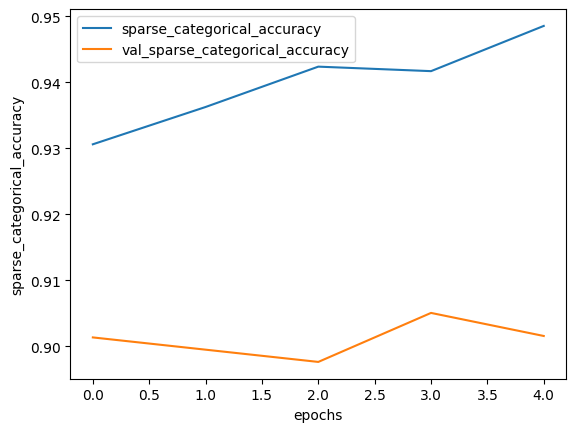

In [ ]:
#batch_size 32
# 훈련셋과 검증셋의 정확도 비교
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], "")
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()
plot_graphs(history, 'sparse_categorical_accuracy')

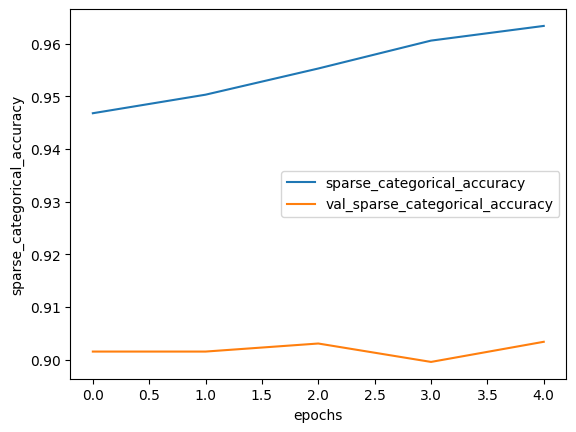

In [ ]:
# 훈련셋과 검증셋의 정확도 비교

#Batch_size = 64
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], "")
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()
plot_graphs(history, 'sparse_categorical_accuracy')

In [ ]:
#Batch_size = 128
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early stop
es = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 4)

tf.keras.callbacks.History()
history = model.fit(X_train, y_train, epochs = 7, batch_size = 128, validation_split = 0.2, callbacks = [es])

Epoch 1/7
286/286 [==============================] - 122s 428ms/step - loss: 0.0787 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.4342 - val_sparse_categorical_accuracy: 0.9056
Epoch 2/7
286/286 [==============================] - 124s 435ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.4702 - val_sparse_categorical_accuracy: 0.9051
Epoch 3/7
286/286 [==============================] - 120s 421ms/step - loss: 0.0591 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.4878 - val_sparse_categorical_accuracy: 0.9039
Epoch 4/7
286/286 [==============================] - 122s 428ms/step - loss: 0.0573 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.4652 - val_sparse_categorical_accuracy: 0.9053
Epoch 5/7
286/286 [==============================] - 121s 422ms/step - loss: 0.0549 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.4797 - val_sparse_categorical_accuracy: 0.9047
Epoch 5: early stopping


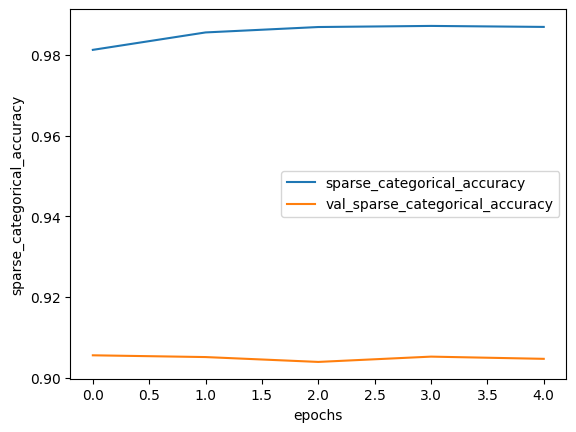

In [ ]:
#batch_size 128
# 훈련셋과 검증셋의 정확도 비교
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], "")
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()
plot_graphs(history, 'sparse_categorical_accuracy')